In [1]:
import logging
import sys
sys.path.insert(0, '/data/programs/probe_position_correction_w_ptychonn/pppc')
sys.path.insert(0, '/data/programs/probe_position_correction_w_ptychonn')

import matplotlib.pyplot as plt
import numpy as np
import cupy
from skimage.transform import resize

import tike
import tike.ptycho
import tike.view

/home/beams/MINGDU/anaconda3/envs/tike/lib/python3.11/site-packages/tike/communicators/mpi.py:414: UserWarning: tike was unable to import mpi4py, so MPI features are unavailable.
  warnings.warn(


In [2]:
def transform_data_for_ptychonn(dp, target_shape, discard_len=None):
    """
    Throw away 1/8 of the boundary region, and resize DPs to match label size.

    :param dp: np.ndarray. The data to be transformed. Can be either 3D [N, H, W] or 2D [H, W].
    :param target_shape: list[int]. The target shape.
    :param discard_len: tuple[int]. The length to discard on each side. If None, the length is default to 1/8 of the raw
                                    image size. If the numbers are negative, the images will be padded instead.
    :return: np.ndarray.
    """
    dp = dp.astype(float)
    if discard_len is None:
        discard_len = [dp.shape[i] // 8 for i in (-2, -1)]
    for i in (0, 1):
        if discard_len[i] > 0:
            slicer = [slice(None)] * (len(dp.shape) - 2)
            slicer_appendix = [slice(None), slice(None)]
            slicer_appendix[i] = slice(discard_len[i], -discard_len[i])
            dp = dp[tuple(slicer + slicer_appendix)]
        elif discard_len[i] < 0:
            pad_len = [(0, 0)] * (len(dp.shape) - 2)
            pad_len_appendix = [(0, 0), (0, 0)]
            pad_len_appendix[i] = (-discard_len[i], -discard_len[i])
            dp = np.pad(dp, np.array(pad_len + pad_len_appendix), mode='constant')
    target_shape = list(dp.shape[:-2]) + list(target_shape)
    if not (target_shape[-1] == dp.shape[-1] and target_shape[-2] == dp.shape[-2]):
        dp = resize(dp, target_shape, preserve_range=True, anti_aliasing=True)
    return dp


def crop_center(img, shape_to_keep=(64, 64)):
    slicer = [slice(None)] * (len(img.shape) - 2)
    for i in range(-2, 0, 1):
        st = (img.shape[i] - shape_to_keep[i]) // 2
        end = st + shape_to_keep[i]
        slicer.append(slice(st, end))
    img = img[tuple(slicer)]
    return img


In [55]:
f = np.load('data/scan235.npz')
data_raw = f['reciprocal']
probe_pos_list_raw = np.genfromtxt('data/pos235.csv', delimiter=',').astype('float32')
probe_raw = np.load('tike_test/scan221_raw.npz')['probe']
probe_raw = probe_raw[0] + 1j * probe_raw[1]
probe_raw = probe_raw.astype('complex64')[None, :, :]
#probe = np.load('data/probe.npy')

print('data size: ', data_raw.shape)
print('probe size: ', probe_raw.shape)

data size:  (961, 256, 256)
probe size:  (1, 256, 256)


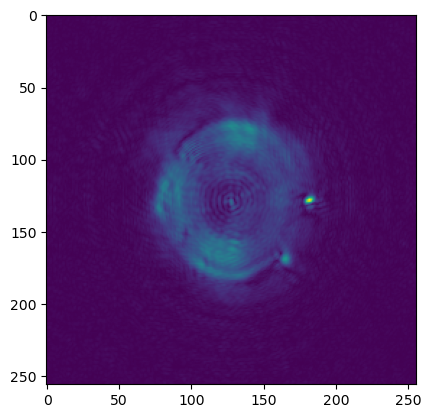

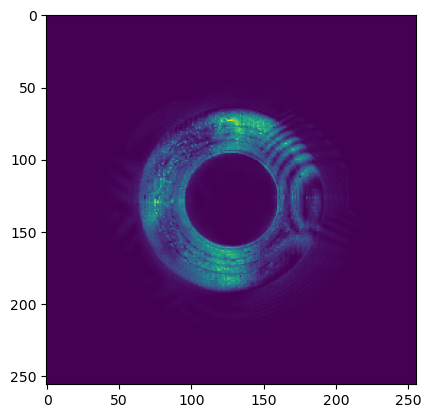

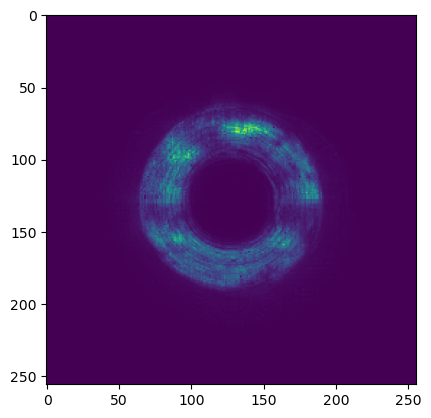

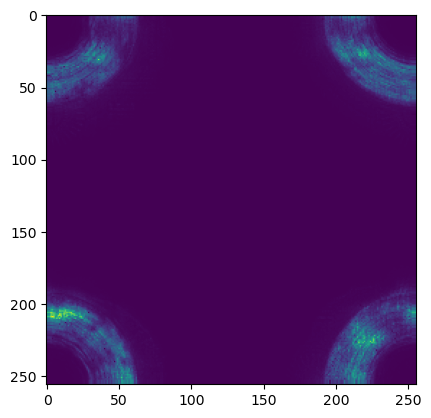

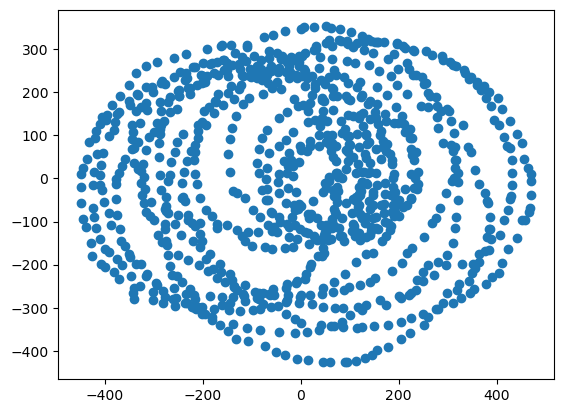

In [56]:
# Data transform:
# Use probe and pixel size in scan221_raw.npz. 
# If DP size is (256, 256), use as it is. (235, 247)
# If DP size is (512, 512), crop it to (256, 256) and flip left-right. 

psize_nm = 7.92

probe_pos_list = probe_pos_list_raw
# probe_pos_list *= -1
# probe_pos_list = probe_pos_list - np.min(probe_pos_list, axis=0)
probe_pos_list = probe_pos_list_raw / (psize_nm * 1e-9)
probe_pos_list = probe_pos_list

data = data_raw
data[data < 0] = 0
data = data.astype('float32')
#data = transform_data_for_ptychonn(data, target_shape=(128, 128), discard_len=(64, 64))
#data = transform_data_for_ptychonn(data, target_shape=(128, 128), discard_len=(192, 192))
#data = data[:, 128:-128, -128:128:-1]
data = np.fft.fftshift(data, axes=(-1, -2))

probe = probe_raw
#probe_real = transform_data_for_ptychonn(probe.real, target_shape=(256, 256), discard_len=None)
#probe_imag = transform_data_for_ptychonn(probe.imag, target_shape=(256, 256), discard_len=None)
#probe = probe_real + 1j * probe_imag
probe = probe[np.newaxis, np.newaxis, :, :, :]
probe = tike.ptycho.probe.add_modes_random_phase(probe, 1)

plt.imshow(np.abs(probe[0, 0, 0]))
plt.show()
plt.imshow(np.fft.ifftshift(np.abs(np.fft.fft2(probe[0, 0, 0])) ** 2))
plt.show()
plt.imshow(np.fft.ifftshift(data[0]))
plt.show()
plt.imshow(data[0])
plt.show()
plt.scatter(probe_pos_list[:, 1], probe_pos_list[:, 0])

In [57]:
probe.shape, probe_pos_list.shape

((1, 1, 1, 256, 256), (961, 2))

In [58]:
psi, probe_pos_list = tike.ptycho.object.get_padded_object(probe_pos_list, probe)

In [59]:
parameters = tike.ptycho.PtychoParameters(
    # Provide initial guesses for parameters that are updated
    probe=probe,
    scan=probe_pos_list,
    psi=psi,
    probe_options=tike.ptycho.ProbeOptions(), # uses default settings for probe recovery
    object_options=tike.ptycho.ObjectOptions(
        # The object will be updated.
        use_adaptive_moment=True,  # smoothness constraint will use our provided setting
        # other object options will be default values
    ),
    position_options=None, # indicates that positions will not be updated
    algorithm_options=tike.ptycho.RpieOptions(
        num_iter=64,
        num_batch=7,
    ),
)

In [60]:
logging.basicConfig(level=logging.INFO)

# returns an updated PtychoParameters object
result = tike.ptycho.reconstruct(
    data=data,
    parameters=parameters,
    num_gpu=2
)

INFO:tike.ptycho.ptycho:rpie on 961 - 256 by 256 frames for at most 64 epochs.
INFO:tike.cluster:Clustering method is wobbly center.
INFO:tike.cluster:Clustering method is wobbly center.
INFO:tike.ptycho.ptycho:Probe rescaled by 103.937436
INFO:tike.ptycho.ptycho:rpie epoch 0
INFO:tike.ptycho.solvers.rpie:  farplane cost is +1.04369e+02
INFO:tike.ptycho.solvers.rpie:  farplane cost is +9.96545e+01
INFO:tike.opt:ADAM decay m=+9.000e-01, v=+9.990e-01; eps=+1.000e-08
INFO:tike.ptycho.solvers.rpie:  farplane cost is +8.07921e+01
INFO:tike.ptycho.solvers.rpie:  farplane cost is +8.13790e+01
INFO:tike.opt:ADAM decay m=+9.000e-01, v=+9.990e-01; eps=+1.000e-08
INFO:tike.ptycho.solvers.rpie:  farplane cost is +6.68109e+01
INFO:tike.ptycho.solvers.rpie:  farplane cost is +6.80515e+01
INFO:tike.opt:ADAM decay m=+9.000e-01, v=+9.990e-01; eps=+1.000e-08
INFO:tike.ptycho.solvers.rpie:  farplane cost is +5.45751e+01
INFO:tike.ptycho.solvers.rpie:  farplane cost is +5.36049e+01
INFO:tike.opt:ADAM deca

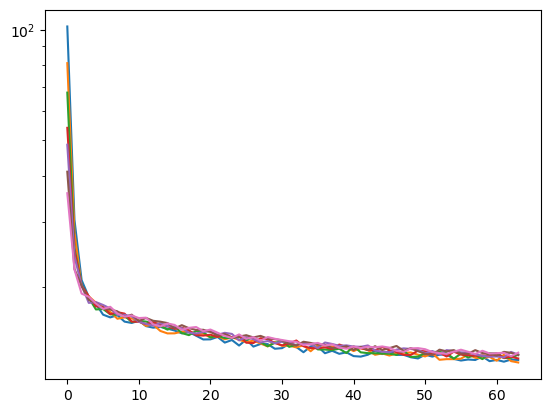

In [61]:
plt.figure()
plt.semilogy(result.algorithm_options.costs)
plt.show()

(0.1015616-0.14204717j) (1.1661899+0.114366725j)


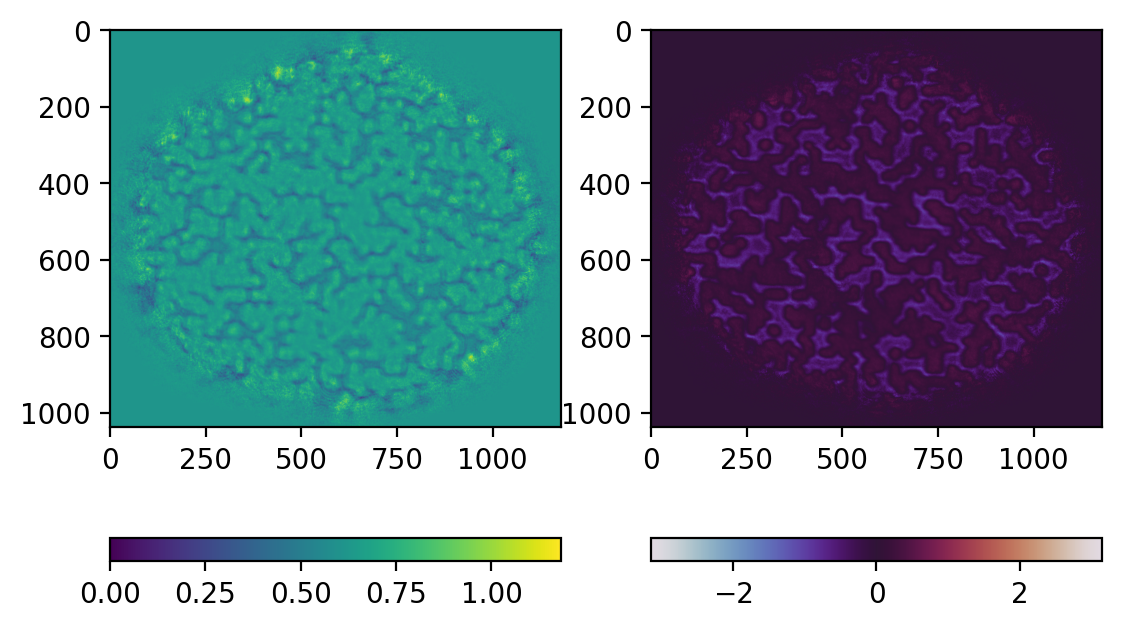

In [62]:
plt.figure(dpi=200)
tike.view.plot_phase(result.psi, amin=0)
plt.show()

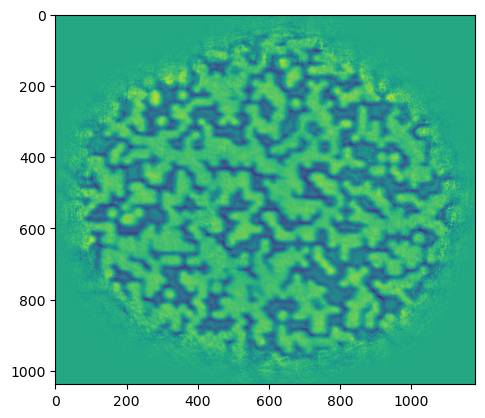

In [63]:
plt.imshow(np.angle(result.psi))
plt.show()